### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership.
```

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
wages = fetch_openml(data_id=534, as_frame=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [ ]:
wages.frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


In [ ]:
wages.frame.describe()


,EDUCATION,EXPERIENCE,WAGE,AGE
count,534.000000,534.000000,534.000000,534.000000
mean,13.018727,17.822097,9.024064,36.833333
std,2.615373,12.379710,5.139097,11.726573
min,2.000000,0.000000,1.000000,18.000000
25%,12.000000,8.000000,5.250000,28.000000
50%,12.000000,15.000000,7.780000,35.000000
75%,15.000000,26.000000,11.250000,44.000000
max,18.000000,55.000000,44.500000,64.000000


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

**EDA and data prep**

<Axes: >

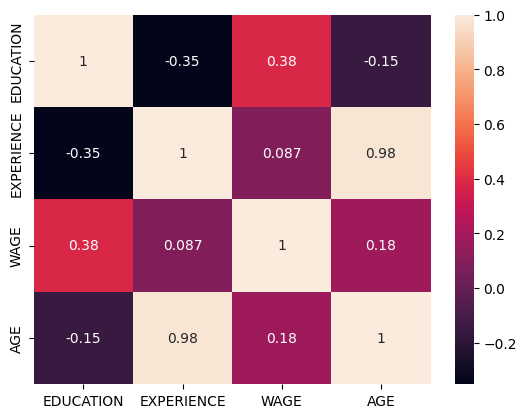

In [ ]:
#Look at correlation heatmap
corr = wages.frame.corr(numeric_only = True)
sns.heatmap(corr, annot = True)


In [ ]:
#Noting that AGE and EXPERIENCE are highly correlated, we drop AGE
wages=wages.frame.drop('AGE', axis=1)

In [ ]:
#Look at values of the categorical features
for column in category:
    print(column, df[column].unique())

SOUTH ['no', 'yes']
Categories (2, object): ['no', 'yes']
SEX ['female', 'male']
Categories (2, object): ['female', 'male']
UNION ['not_member', 'member']
Categories (2, object): ['member', 'not_member']
RACE ['Hispanic', 'White', 'Other']
Categories (3, object): ['Hispanic', 'Other', 'White']
OCCUPATION ['Other', 'Management', 'Sales', 'Clerical', 'Service', 'Professional']
Categories (6, object): ['Clerical', 'Management', 'Other', 'Professional', 'Sales', 'Service']
SECTOR ['Manufacturing', 'Other', 'Construction']
Categories (3, object): ['Construction', 'Manufacturing', 'Other']
MARR ['Married', 'Unmarried']
Categories (2, object): ['Married', 'Unmarried']


**Feature engineering and pre-processing**

In [ ]:
#Split data into target and independent features, using log of target variable
X = df.drop('WAGE', axis=1)
y = np.log(df['WAGE'])
print(X.shape)
print(y.shape)


(534, 10)
(534,)


In [ ]:
# Define categorical and numerical features
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = X.select_dtypes(include=['number']).columns.tolist()

print('categorical_columns:', categorical_columns)
print('numeric_columns:', numeric_columns)

# Create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias = False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge()),
])

categorical_columns: ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
numeric_columns: ['EDUCATION', 'EXPERIENCE', 'AGE']


In [ ]:
# Create transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias = False))
])

#Build a preprocessor to create dummies from categorical features and normalize numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('Numeric', make_pipeline(PolynomialFeatures(degree=3, include_bias=False), StandardScaler()), numerical),
        ('Categorical', make_pipeline(OneHotEncoder(drop='if_binary')), categorical)],
      verbose_feature_names_out=True)
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge()),
])
pipeline



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['EDUCATION', 'EXPERIENCE'], dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object'))])),
                ('regressor', Ridge())])

In [ ]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 10)
(160,)
(374, 10)
(374,)


In [ ]:
# Create a TransformedTargetRegressor with the pipeline and log transformation
regressor = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

# params for grid search
param_grid = {
    'regressor__regressor__alpha': [0.1, 1.0, 10.0]
}

gs = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

print(f'best params: {gs.best_params_}')
print(f'best MSE  {-1.0 * gs.best_score_:.2f}')


best params: {'regressor__regressor__alpha': 10.0}
best MSE  0.20


In [ ]:
# Calculate Permutation importance

best_estimator = gs.best_estimator_

importance = permutation_importance(estimator=best_estimator, X=X_test, y=y_test, random_state=42)
importance_df = pd.DataFrame({'features': X.columns, 'importance': importance.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df



,features,importance
0,EDUCATION,0.275933
3,EXPERIENCE,0.153975
2,SEX,0.073329
7,OCCUPATION,0.050156
4,UNION,0.026632
1,SOUTH,0.018531
8,SECTOR,0.005573
9,MARR,0.005091
5,AGE,0.000000
6,RACE,-0.004328
